In [1]:
%matplotlib inline

import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from scipy.signal import find_peaks, peak_widths
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

In [2]:
FACE_MESH = pd.read_csv('faceMesh/face_mesh.csv')

def landmarks_mapper(video: str, cleansed_data: bool):
    
    OPENFACE_LANDMARKS = [i for i in range(17, 68)]
    
    if cleansed_data:
        OPENFACE_DIR = 'openFace/processed_cleansed/'
        MEDIAPIPE_DIR = 'mediaPipe/processed_cleansed/'
    else:
        OPENFACE_DIR = 'openFace/processed/'
        MEDIAPIPE_DIR = 'mediaPipe/processed/'
        
    of_df = pd.read_csv(OPENFACE_DIR + video + '_openface.csv')
    mp_df = pd.read_csv(MEDIAPIPE_DIR + video + '_mediapipe.csv')
    
    final_df = of_df['frame'] # initialize the final dataframe
    for i, landmark in enumerate(OPENFACE_LANDMARKS):

        mask = (FACE_MESH['openFace_landmark'] == landmark) # group the mediapipe landmarks by the openface landmark

        tmp1_df = of_df[[f'x_{landmark}', f'y_{landmark}']] # select the columns from the openface dataframe
        tmp1_df.columns = [f'openface_x_{landmark}', f'openface_y_{landmark}'] # rename the columnsk
        
        mediaPipe_landmarks_X = ['x_'+str(ID) for ID in FACE_MESH[mask].id] # collect the X coordinate
        mediaPipe_landmarks_Y = ['y_'+str(ID) for ID in FACE_MESH[mask].id] # collect the Y coordinate
        
        tmp2_df = pd.DataFrame({f'mediapipe_x_{landmark}':mp_df[mediaPipe_landmarks_X].mean(axis=1),
                                f'mediapipe_y_{landmark}':mp_df[mediaPipe_landmarks_Y].mean(axis=1)})
        
        final_df = pd.concat([final_df, tmp1_df, tmp2_df], axis=1)
        
    return final_df

In [4]:
def mse(df: pd.DataFrame):
    
    lndmk_mse = []
    for i in range(17, 68):
        
        x_mse = mean_squared_error(df[f'mediapipe_x_{i}'].to_numpy(), df[f'openface_x_{i}'].to_numpy())
        y_mse = mean_squared_error(df[f'mediapipe_y_{i}'].to_numpy(), df[f'openface_y_{i}'].to_numpy())
        lndmk_mse.append((x_mse+y_mse)/2)
    
    video_mse = np.mean(lndmk_mse)
    
    return video_mse

In [5]:
video_name = '50_50_4'
window_size = (lambda seconds: round(24*seconds))(0.2)
mapped_landmarks_df = landmarks_mapper(video_name, cleansed_data=True)
windows = mapped_landmarks_df.rolling(window=window_size, center=True)
windowized_mse = preprocessing.normalize([[mse(window) for window in windows]], norm='max').flatten()

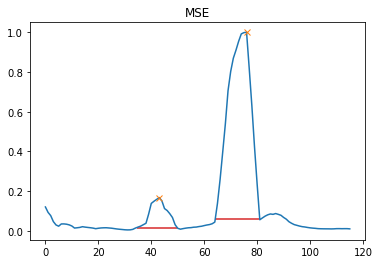

In [7]:
plt.plot(windowized_mse)
plt.title('MSE')

peaks, _ = find_peaks(windowized_mse, height=0.15)
widths = peak_widths(windowized_mse, peaks, rel_height=0.95)

plt.plot(peaks, windowized_mse[peaks], 'x')
plt.hlines(*widths[1:], color="C3")

plt.show()